# Basic distributed model prediction
This test uses ResNet 50 to perform inference on random noise images.

Goals:
- Figure out how to do inference on dask
- Simulate ESI data by using xarrays
- Try to chunk image data properly
- Use GPUs somehow??

In [49]:
import dask.array as da
import numpy as np
import xarray as xr
import torch
import torchvision.models as models
from dask_gateway import Gateway
from dask.distributed import Client



In [28]:

# Set up Dask cluster

gateway = Gateway()

# CUDA stuff here
options = gateway.cluster_options()
#options.cuda_worker = True 
# options.node_selection = "all"

# print("Requesting GPU Cluster via dask-cuda-worker...")
# try:
#     cluster = gateway.new_cluster(cluster_options=options)
#     cluster.scale(2) # try with 2?
#     client = cluster.get_client()
#     print("Cluster Dashboard:", client.dashboard_link)
# except Exception as e:
#     print("Cluster failed to start. You might not have GPU quota or the system is busy.")
#     print(e)



In [16]:
# print(f"{'PYTHON ATTRIBUTE':<30} | {'GUI LABEL':<30} | {'CURRENT VALUE'}")
# print("-" * 90)

# for name, field in options._fields.items():
#     # getattr(obj, name) gets the value of the attribute dynamically
#     value = getattr(options, name)
    
#     # Print formatted columns
#     print(f"options.{name:<22} | {field.label:<30} | {str(value)}")

In [1]:
# Cluster stuff
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster()
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

# Scale up
num_workers = 2
cluster.scale(num_workers)
client = cluster.get_client()
print("Cluster Dashboard:", client.dashboard_link)

def check_gpu_status():
    import torch
    import os
    return {
        "gpu_available": torch.cuda.is_available(),
        "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None"
    }

#print("\nWaiting for workers...")
client.wait_for_workers(1)

print("Worker Status:")
info = client.run(check_gpu_status)
for worker, result in info.items():
    print(f"Worker {worker[-6:]}: {result}")
    
    if not result['gpu_available']:
        print("WARNING: This worker is CPU-only. The system ignored the cuda request.")

NameError: name 'gateway' is not defined

In [119]:
#client.restart()


In [50]:
# Download model structure/weights on the notebook (driver)
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_state = resnet.state_dict()

# Scatter the weights to all workers memory immediately
# This makes looking up weights very fast for the workers later
future_list = client.scatter([model_state] broadcast=True)
single_future = future_list[0]


Data Structure:


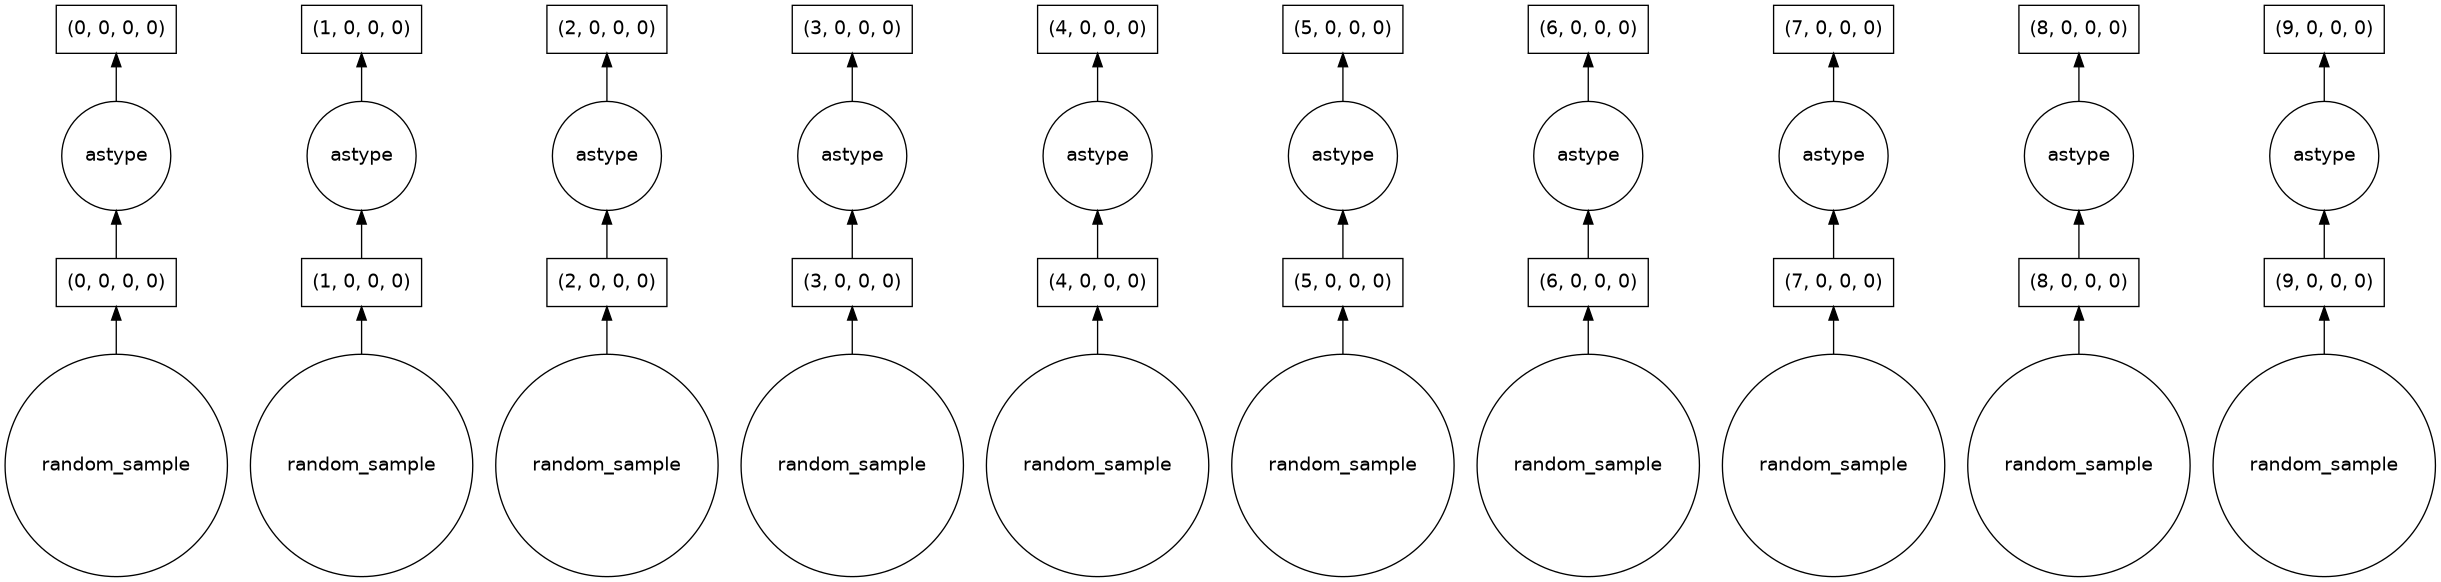

In [51]:
num_images = 100
chunk_size = 10

# Random data simulating normalized images
data_dask = da.random.random((num_images, 3, 224, 224), chunks=(chunk_size, 3, 224, 224)).astype('float32')

# Wrap in Xarray
ds = xr.DataArray(
    data_dask,
    dims=("index", "channel", "y", "x"),
    name="input_images"
)
ds = ds.assign_coords(index=np.arange(num_images))


print("\nData Structure:")
ds.data.visualize()

In [52]:
def predict_block(data_block, weights_future):
    
    # 1. Handle Future/Dict
    if hasattr(weights_future, 'result'):
        state_dict = weights_future.result()
    else:
        state_dict = weights_future

    # 2. Model Setup
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 1000)
    model.load_state_dict(state_dict)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # 3. Get data
    numpy_data = data_block.values 
    inputs = torch.from_numpy(numpy_data).float().to(device)
    
    # 4. Inference
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        
    # 5. RETURN WITH COORDINATES
    # Because we ran Step 1, data_block.coords["index"] is now correct (e.g., 70-80)
    # This satisfies the template requirement.
    return xr.DataArray(
        probs.cpu().numpy(),
        dims=("index", "classes"),
        coords={
            "index": data_block.coords["index"], # This is now safe to include
            "classes": np.arange(1000)
        }
    )


Setting up lazy computation graph...


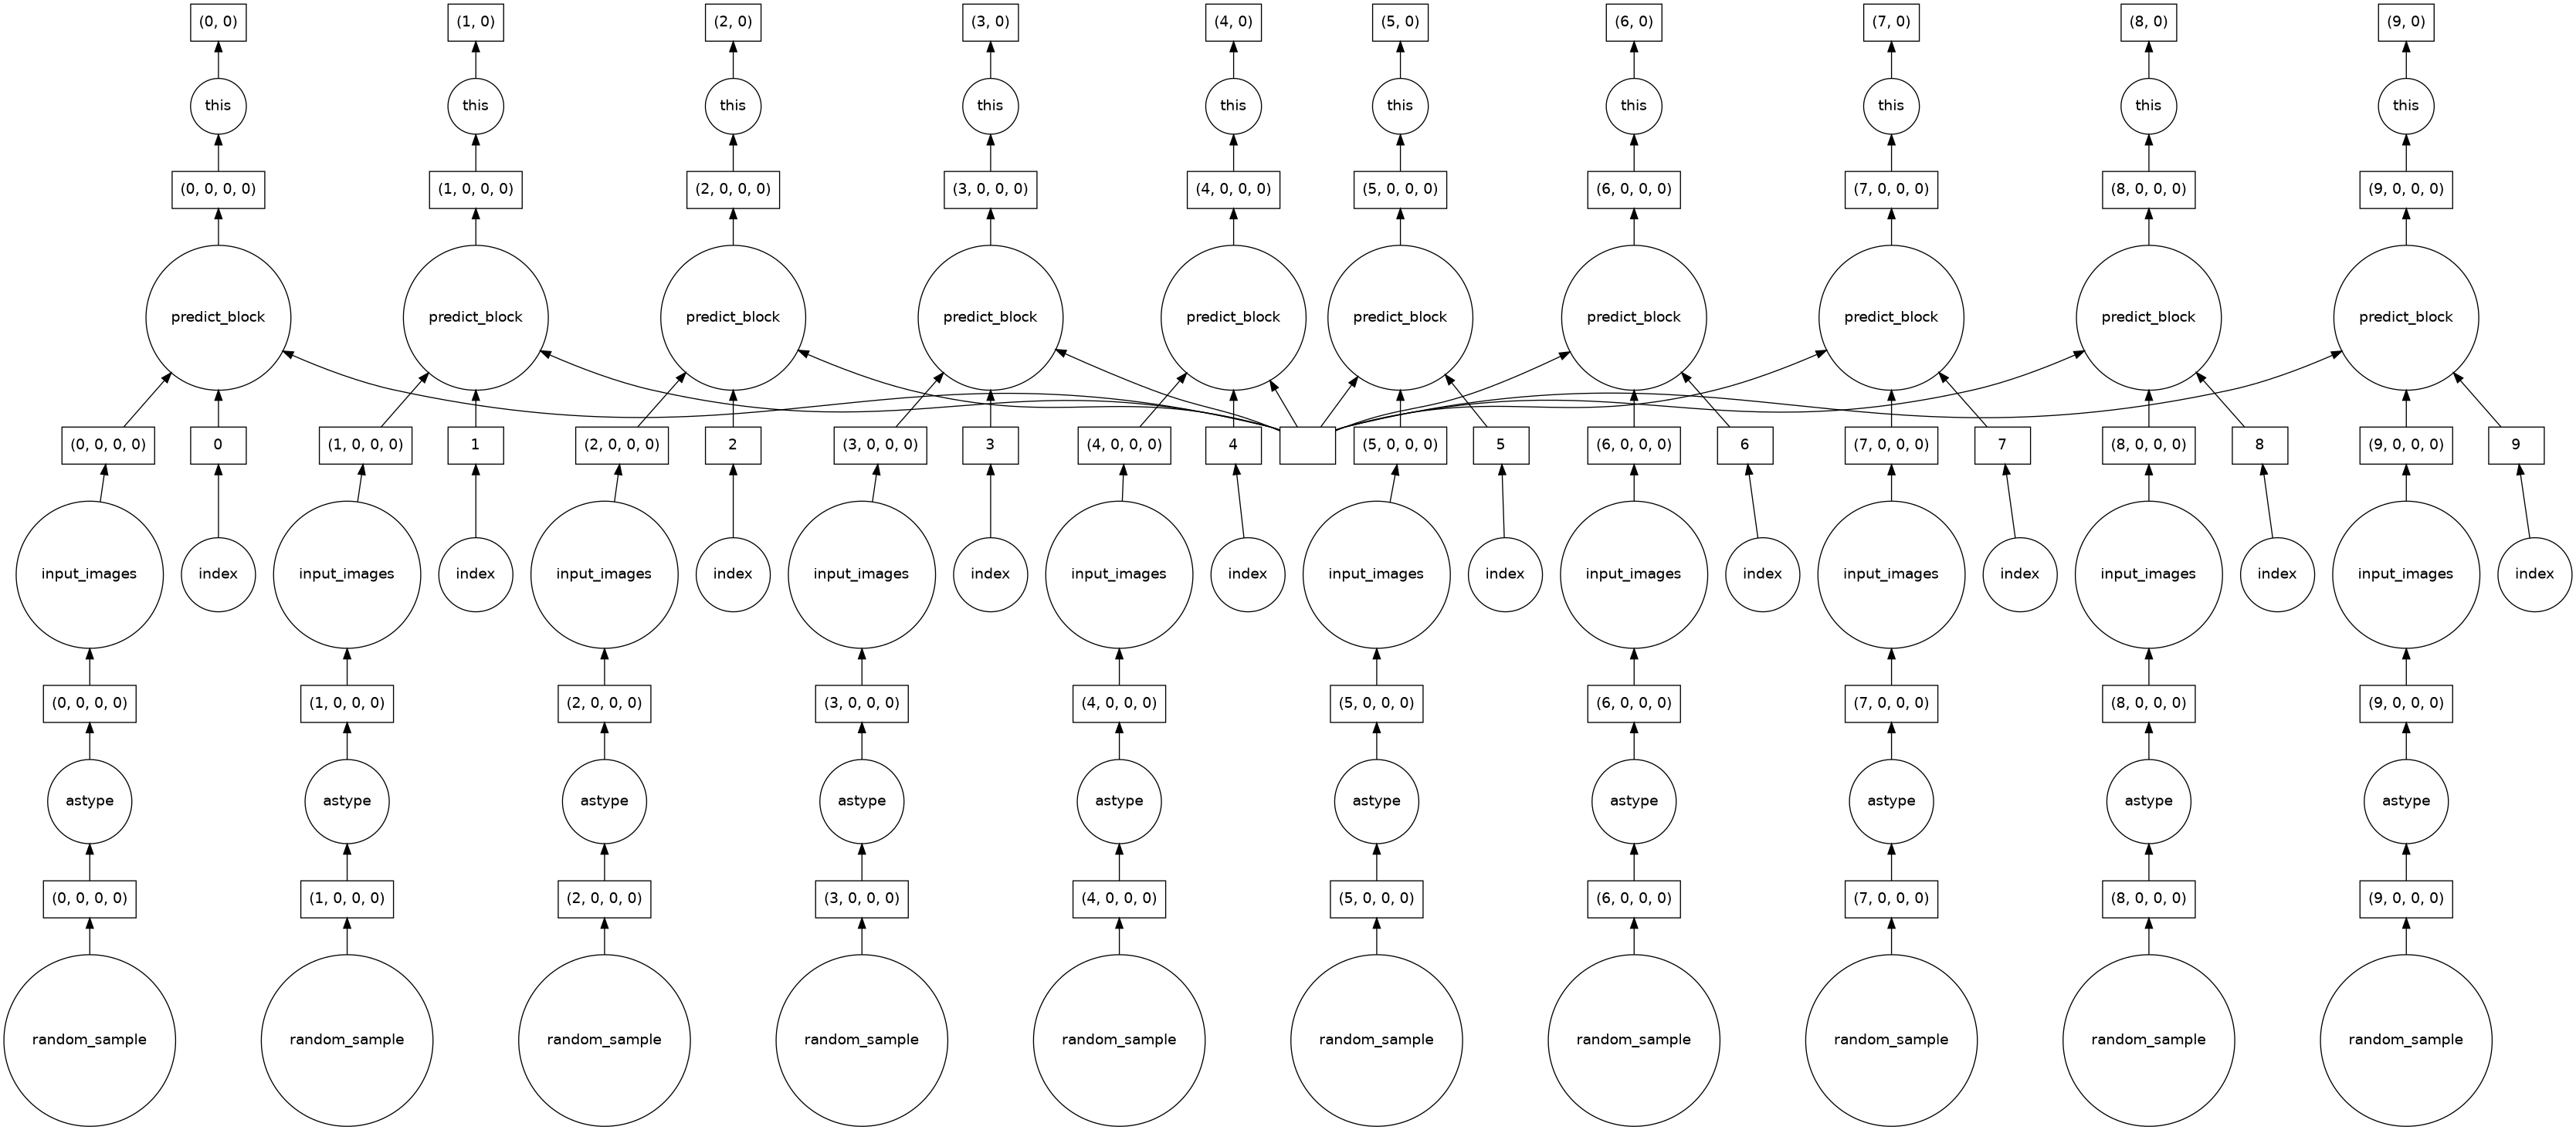

In [53]:
template = xr.DataArray(
    da.empty((num_images, 1000), chunks=(chunk_size, 1000)), 
    dims=("index", "classes"),
    coords={"index": ds.index, "classes": np.arange(1000)}
)


print("\nSetting up lazy computation graph...")

# This is the magic command used for ESI data
predictions = ds.map_blocks(
    predict_block,
    kwargs={"weights_future": single_future},
    template=template
)

predictions.data.visualize()

In [54]:

print("\nStarting distributed inference...")
results = predictions.compute()
print("Done!")
print("Final Output Shape:", results.shape) # Should be (100, 1000)


Starting distributed inference...
Done!
Final Output Shape: (100, 1000)


In [55]:
results

<xarray.DataArray 'empty_like-b2a2ded4fad333a65245b9372886721b' (index: 100,
                                                                 classes: 1000)> Size: 400kB
array([[0.00016022, 0.00047048, 0.00029708, ..., 0.00021337, 0.00028513,
        0.00360137],
       [0.00014838, 0.00043419, 0.00030367, ..., 0.00019663, 0.00028024,
        0.00345311],
       [0.00017141, 0.00047313, 0.00031748, ..., 0.00022766, 0.00030656,
        0.00383073],
       ...,
       [0.0001659 , 0.00045688, 0.0003112 , ..., 0.00022043, 0.00029667,
        0.00353933],
       [0.00016508, 0.0004444 , 0.0003327 , ..., 0.00022029, 0.00030616,
        0.00354235],
       [0.00016024, 0.00043386, 0.00028878, ..., 0.00021984, 0.00028635,
        0.00358301]], shape=(100, 1000), dtype=float32)
Coordinates:
  * index    (index) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * classes  (classes) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [56]:
# Sum probabilities across the 'classes' dimension
row_sums = results.sum(dim="classes")

# Check the first 5 images. They should all be extremely close to 1.00000
print("Row Sums (Should be ~1.0):")
print(row_sums[:5].values)

# rigorous check: ensure all 100 images sum to 1 within floating point error
assert np.allclose(row_sums, 1.0, atol=1e-5)
print("Math Check Passed: All predictions are valid probabilities.")

Row Sums (Should be ~1.0):
[0.9999999  0.99999994 1.         1.         1.0000001 ]
Math Check Passed: All predictions are valid probabilities.


In [57]:
# Compare the prediction for Image 0 vs Image 1
are_identical = np.allclose(results[0].values, results[1].values)

if not are_identical:
    print("✅ Integrity Check Passed: Image 0 and Image 1 have different predictions.")
else:
    print("❌ FAIL: The model predicted the exact same thing for different images.")

✅ Integrity Check Passed: Image 0 and Image 1 have different predictions.


In [58]:
# 1. Modify the original lazy array
# We are effectively "drawing" a bright green box on Image 50
# ResNet usually thinks bright solid colors are 'screens', 'envelopes' or 'paper'
data_dask_modified = data_dask.copy()
# Set Image 50, Channel 1 (Green), to 1.0 (max brightness)
# Note: We use dask slicing. This doesn't compute anything yet.
data_dask_modified[50, 0, :, :] = 0.0 # R
data_dask_modified[50, 1, :, :] = 1.0 # G
data_dask_modified[50, 2, :, :] = 0.0 # B

# 2. Wrap in Xarray again (Don't forget the coords fix we learned!)
ds_mod = xr.DataArray(
    data_dask_modified,
    dims=("index", "channel", "y", "x"),
    coords={"index": np.arange(num_images)},
    name="input_images"
)

# 3. Map blocks again
predictions_mod = ds_mod.map_blocks(
    predict_block,
    kwargs={"weights_future": single_future}, 
    template=template
)

# 4. Compute ONLY Image 50 (Dask is smart, it won't compute the others!)
print("Computing only Image 50...")
result_50 = predictions_mod.sel(index=[50]).compute()

# 5. Get the top predicted class ID
top_class_id = result_50[0].argmax().item()
confidence = result_50[0].max().item()

print(f"✅ Logic Check Passed.") 
print(f"For the Solid Green image, ResNet predicts Class ID: {top_class_id}")
print(f"Confidence: {confidence:.4f}")

Computing only Image 50...
✅ Logic Check Passed.
For the Solid Green image, ResNet predicts Class ID: 111
Confidence: 0.0328


In [59]:

client.close()
cluster.shutdown()